In [ ]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 2.6 MB/s eta 0:00:00


# Librerías y Ruta

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


import scipy.stats

from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier

from category_encoders import CountEncoder

from xgboost import XGBRegressor
from xgboost import XGBClassifier

In [ ]:
ruta_datasets = '/content/drive/MyDrive/dedalus_datathon/datasets/'

# Dataset Paciente

## Carga del Dataset

In [ ]:
data = pd.read_csv(ruta_datasets+"patient.csv")

In [ ]:
data.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,...,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid
0,141764,129391,Female,87,Caucasian,59,91,NaN,157.5,23:36:00,...,ICU to SDU,2,stepdown/other,NaN,NaN,18:58:00,344,Home,Alive,002-1039
1,141765,129391,Female,87,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",157.5,23:36:00,...,Emergency Department,1,admit,46.5,45.0,13:14:00,2250,Step-Down Unit (SDU),Alive,002-1039
2,143870,131022,Male,76,Caucasian,68,103,"Endarterectomy, carotid",167.0,20:46:00,...,Operating Room,1,admit,77.5,79.4,10:00:00,793,Floor,Alive,002-12289
3,144815,131736,Female,34,Caucasian,56,82,"Overdose, other toxin, poison or drug",172.7,01:44:00,...,Emergency Department,1,admit,60.3,60.7,20:48:00,1121,Other External,Alive,002-1116
4,145427,132209,Male,61,Caucasian,68,103,"GI perforation/rupture, surgery for",177.8,23:48:00,...,Operating Room,1,admit,91.7,93.1,22:47:00,1369,Floor,Alive,002-12243


## Análisis Previo

In [ ]:
data = data[['patientunitstayid', 'gender', 'age', 'hospitalid', 'apacheadmissiondx','admissionheight', 'unittype',
             'unitadmitsource', 'unitvisitnumber', 'unitstaytype', 'unitdischargeoffset']]

In [ ]:
data.shape

(2520, 11)

In [ ]:
data.dtypes

patientunitstayid        int64
gender                  object
age                     object
hospitalid               int64
apacheadmissiondx       object
admissionheight        float64
unittype                object
unitadmitsource         object
unitvisitnumber          int64
unitstaytype            object
unitdischargeoffset      int64
dtype: object

In [ ]:
data.describe()

,patientunitstayid,hospitalid,admissionheight,unitvisitnumber,unitdischargeoffset
count,2.520000e+03,2520.000000,2451.000000,2520.000000,2520.000000
mean,1.666226e+06,261.042460,169.740445,1.200000,3484.075000
std,1.022224e+06,119.109829,15.986092,0.510003,4977.160994
min,1.417640e+05,56.000000,0.300000,1.000000,0.000000
25%,7.722628e+05,158.000000,162.600000,1.000000,1137.750000
50%,1.590372e+06,252.500000,170.200000,1.000000,2120.000000
75%,2.697422e+06,384.500000,177.800000,1.000000,3998.500000
max,3.353113e+06,459.000000,600.000000,5.000000,66499.000000


In [ ]:
data.describe(exclude=[np.number])

,gender,age,apacheadmissiondx,unittype,unitadmitsource,unitstaytype
count,2516,2516,2221,2520,2498,2520
unique,2,76,236,8,13,4
top,Male,> 89,"Sepsis, pulmonary",Med-Surg ICU,Emergency Department,admit
freq,1508,98,121,1898,1304,2064


In [ ]:
data.isnull().sum() / data.shape[0]

patientunitstayid      0.000000
gender                 0.001587
age                    0.001587
hospitalid             0.000000
apacheadmissiondx      0.118651
admissionheight        0.027381
unittype               0.000000
unitadmitsource        0.008730
unitvisitnumber        0.000000
unitstaytype           0.000000
unitdischargeoffset    0.000000
dtype: float64

In [ ]:
for col in data.columns[data.dtypes==object]:
    display((data.groupby([col]).size()/data.shape[0]).reset_index(name='counts'))

,gender,counts
0,Female,0.400000
1,Male,0.598413


,age,counts
0,15,0.000397
1,16,0.000397
2,17,0.000794
3,18,0.003175
4,19,0.003175
...,...,...
71,86,0.010317
72,87,0.017063
73,88,0.009921
74,89,0.011508


,apacheadmissiondx,counts
0,"ARDS-adult respiratory distress syndrome, non-...",0.003571
1,Abdomen only trauma,0.000397
2,Abdomen/extremity trauma,0.000794
3,Abdomen/multiple trauma,0.000397
4,Ablation or mapping of cardiac conduction pathway,0.000794
...,...,...
231,"Vascular medical, other",0.002778
232,"Vascular surgery, other",0.000794
233,Vena cava filter insertion,0.000397
234,Ventriculostomy,0.000397


,unittype,counts
0,CCU-CTICU,0.032540
1,CSICU,0.025794
2,CTICU,0.020635
3,Cardiac ICU,0.052778
4,MICU,0.056349
5,Med-Surg ICU,0.753175
6,Neuro ICU,0.025794
7,SICU,0.032937


,unitadmitsource,counts
0,Acute Care/Floor,0.022222
1,Chest Pain Center,0.000794
2,Direct Admit,0.055952
3,Emergency Department,0.517460
4,Floor,0.130952
5,ICU,0.020635
6,ICU to SDU,0.058730
7,Operating Room,0.100397
8,Other Hospital,0.009921
9,Other ICU,0.012302


,unitstaytype,counts
0,admit,0.819048
1,readmit,0.038492
2,stepdown/other,0.110714
3,transfer,0.031746


## Tratamiento Features

In [ ]:
data = data[['patientunitstayid', 'gender', 'age', 'hospitalid', 'apacheadmissiondx','admissionheight', 'unittype',
             'unitadmitsource', 'unitvisitnumber', 'unitstaytype', 'unitdischargeoffset']]

In [ ]:
data.dtypes

patientunitstayid        int64
gender                  object
age                     object
hospitalid               int64
apacheadmissiondx       object
admissionheight        float64
unittype                object
unitadmitsource         object
unitvisitnumber          int64
unitstaytype            object
unitdischargeoffset      int64
dtype: object

In [ ]:
data.loc[data['age'] == '> 89', ['age']] = 90
data['age'] = data['age'].fillna(-1).astype(int)

In [ ]:
data['gender'].unique()

array(['Female', 'Male', nan], dtype=object)

# Past History Dataset

## Carga dataset

In [ ]:
past_history = pd.read_csv(ruta_datasets+"pastHistory.csv")

In [ ]:
past_history.head()

,pasthistoryid,patientunitstayid,pasthistoryoffset,pasthistoryenteredoffset,pasthistorynotetype,pasthistorypath,pasthistoryvalue,pasthistoryvaluetext
0,990803,141765,7,12,Comprehensive Progress,notes/Progress Notes/Past History/Past History...,No Health Problems,NoHealthProblems
1,970059,143870,4,10,Comprehensive Progress,notes/Progress Notes/Past History/Past History...,No Health Problems,NoHealthProblems
2,1180401,144815,32,41,Comprehensive Progress,notes/Progress Notes/Past History/Past History...,No Health Problems,NoHealthProblems
3,1194998,145427,8,13,Comprehensive Progress,notes/Progress Notes/Past History/Past History...,No Health Problems,NoHealthProblems
4,896652,147307,53,56,Comprehensive Progress,notes/Progress Notes/Past History/Past History...,No Health Problems,NoHealthProblems


## Análisis Previo

In [ ]:
past_history.shape

(12109, 8)

In [ ]:
past_history.dtypes

pasthistoryid                int64
patientunitstayid            int64
pasthistoryoffset            int64
pasthistoryenteredoffset     int64
pasthistorynotetype         object
pasthistorypath             object
pasthistoryvalue            object
pasthistoryvaluetext        object
dtype: object

In [ ]:
past_history.describe()

,pasthistoryid,patientunitstayid,pasthistoryoffset,pasthistoryenteredoffset
count,1.210900e+04,1.210900e+04,12109.000000,12109.000000
mean,1.155916e+07,1.903050e+06,1033.009002,1116.320423
std,6.567584e+06,1.026370e+06,3055.118424,2857.771688
min,8.480350e+05,1.417650e+05,-42622.000000,-1933.000000
25%,5.955936e+06,1.054428e+06,16.000000,36.000000
50%,1.137201e+07,1.820689e+06,59.000000,101.000000
75%,1.666365e+07,2.883334e+06,607.000000,719.000000
max,2.235089e+07,3.353113e+06,28637.000000,28649.000000


In [ ]:
past_history.describe(exclude=[np.number])

,pasthistorynotetype,pasthistorypath,pasthistoryvalue,pasthistoryvaluetext
count,12109,12109,12109,12109
unique,6,190,174,174
top,Admission,notes/Progress Notes/Past History/Past History...,Performed,Performed
freq,7096,2998,2998,2998


In [ ]:
past_history.isnull().sum() / past_history.shape[0]

pasthistoryid               0.0
patientunitstayid           0.0
pasthistoryoffset           0.0
pasthistoryenteredoffset    0.0
pasthistorynotetype         0.0
pasthistorypath             0.0
pasthistoryvalue            0.0
pasthistoryvaluetext        0.0
dtype: float64

In [ ]:
for col in past_history.columns[past_history.dtypes==object]:
    display((past_history.groupby([col]).size()/past_history.shape[0]).reset_index(name='counts'))

,pasthistorynotetype,counts
0,Admission,0.586010
1,Comprehensive Progress,0.304815
2,Follow-up Consultation/Other,0.015856
3,Initial Consultation/Other,0.005368
4,Past History Edit,0.056652
5,Re-Admission,0.031299


,pasthistorypath,counts
0,notes/Progress Notes/Past History/Organ System...,0.004212
1,notes/Progress Notes/Past History/Organ System...,0.004294
2,notes/Progress Notes/Past History/Organ System...,0.000083
3,notes/Progress Notes/Past History/Organ System...,0.000083
4,notes/Progress Notes/Past History/Organ System...,0.001074
...,...,...
185,notes/Progress Notes/Past History/Organ System...,0.000165
186,notes/Progress Notes/Past History/Past History...,0.019737
187,notes/Progress Notes/Past History/Past History...,0.002643
188,notes/Progress Notes/Past History/Past History...,0.001982


,pasthistoryvalue,counts
0,>= 20 mg prednisone per day or equivalent,0.000661
1,A paced,0.000495
2,A/V paced,0.001404
3,AICD,0.004212
4,ALL,0.000083
...,...,...
169,uterus,0.000578
170,varices,0.000908
171,ventricular ectopy,0.000495
172,ventricular fibrillation,0.000083


,pasthistoryvaluetext,counts
0,>= 20 mg prednisone per day or equivalent,0.000661
1,A paced,0.000495
2,A/V paced,0.001404
3,AICD,0.004212
4,ALL,0.000083
...,...,...
169,uterus,0.000578
170,varices,0.000908
171,ventricular ectopy,0.000495
172,ventricular fibrillation,0.000083


## Tratamiento Features

In [ ]:
past_history['pasthistorysplit'] = past_history['pasthistorypath'].str.split('/').str[4]

In [ ]:
past_history['pasthistorysplit'].unique()

array(['No Health Problems', 'Performed', 'Endocrine (R)', 'Hematology',
       'Pulmonary', 'Cardiovascular (R)', 'Neurologic',
       'Infectious Disease (R)', 'Renal  (R)', 'Gastrointestinal (R)',
       'Rheumatic', 'Not Performed', 'Not Obtainable'], dtype=object)

In [ ]:
past_history.isnull().sum() / past_history.shape[0]

pasthistoryid               0.0
patientunitstayid           0.0
pasthistoryoffset           0.0
pasthistoryenteredoffset    0.0
pasthistorynotetype         0.0
pasthistorypath             0.0
pasthistoryvalue            0.0
pasthistoryvaluetext        0.0
pasthistorysplit            0.0
dtype: float64

In [ ]:
past_history = past_history.loc[past_history['pasthistorysplit'] != 'No Health Problems', :]
past_history = past_history.loc[past_history['pasthistorysplit'] != 'Performed', :]
past_history = past_history.loc[past_history['pasthistorysplit'] != 'Not Performed', :]
past_history = past_history.loc[past_history['pasthistorysplit'] != 'Not Obtainable', :]

In [ ]:
past_history['pasthistorysplit'].unique()

array(['Endocrine (R)', 'Hematology', 'Pulmonary', 'Cardiovascular (R)',
       'Neurologic', 'Infectious Disease (R)', 'Renal  (R)',
       'Gastrointestinal (R)', 'Rheumatic'], dtype=object)

In [ ]:
past_history = past_history[['pasthistoryid', 'patientunitstayid', 'pasthistorysplit']]

In [ ]:
past_history.shape

(8816, 3)

In [ ]:
past_history.pivot_table('pasthistorysplit', index=['patientunitstayid'], aggfunc='count')

,pasthistorysplit
patientunitstayid,
147784,1
151179,2
151900,4
153972,8
155961,1
...,...
3351763,6
3352230,6
3352231,2


In [ ]:
paciente_pastHistory = pd.DataFrame({'patientunitstayid': past_history['patientunitstayid'].unique()})
paciente_pastHistory.head()

,patientunitstayid
0,147784
1,151179
2,151900
3,153972
4,155961


In [ ]:
pivot_table = pd.pivot_table(past_history, index='patientunitstayid', columns='pasthistorysplit', values='pasthistoryid', aggfunc=lambda x: 1)

In [ ]:
paciente_pastHistory = paciente_pastHistory.merge(pivot_table, on='patientunitstayid', how='left').fillna(0)

In [ ]:
paciente_pastHistory.head()

,patientunitstayid,Cardiovascular (R),Endocrine (R),Gastrointestinal (R),Hematology,Infectious Disease (R),Neurologic,Pulmonary,Renal (R),Rheumatic
0,147784,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,151179,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,151900,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,153972,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,155961,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
paciente_pastHistory.shape

(1838, 10)

# Vital Periodic

## Carga dataset

In [ ]:
vital_periodic = pd.read_csv(ruta_datasets+"vitalPeriodic.csv")

In [ ]:
vital_periodic.head()

,vitalperiodicid,patientunitstayid,observationoffset,temperature,sao2,heartrate,respiration,cvp,etco2,systemicsystolic,systemicdiastolic,systemicmean,pasystolic,padiastolic,pamean,st1,st2,st3,icp
0,29524122,141765,1179,NaN,NaN,82.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29557845,141765,189,NaN,97.0,76.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29524442,141765,1169,NaN,NaN,84.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,29513052,141765,1534,NaN,NaN,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,29524600,141765,1164,NaN,NaN,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Análisis Previo

In [ ]:
vital_periodic.shape

(1634960, 19)

In [ ]:
vital_periodic.dtypes

vitalperiodicid        int64
patientunitstayid      int64
observationoffset      int64
temperature          float64
sao2                 float64
heartrate            float64
respiration          float64
cvp                  float64
etco2                float64
systemicsystolic     float64
systemicdiastolic    float64
systemicmean         float64
pasystolic           float64
padiastolic          float64
pamean               float64
st1                  float64
st2                  float64
st3                  float64
icp                  float64
dtype: object

In [ ]:
vital_periodic.describe()

,vitalperiodicid,patientunitstayid,observationoffset,temperature,sao2,heartrate,respiration,cvp,etco2,systemicsystolic,systemicdiastolic,systemicmean,pasystolic,padiastolic,pamean,st1,st2,st3,icp
count,1.634960e+06,1.634960e+06,1.634960e+06,112820.000000,1.441700e+06,1.627894e+06,1.381351e+06,202284.000000,72780.000000,226475.000000,226471.000000,228400.000000,32083.000000,32080.000000,32632.000000,613267.000000,656963.000000,596372.000000,13193.000000
mean,1.073732e+09,1.763917e+06,5.430636e+03,38.677957,9.645519e+01,8.546431e+01,2.011894e+01,36.530358,29.464427,124.276839,59.338816,80.989046,37.089175,18.766022,26.203205,1.541094,2.990486,3.120847,7.416888
std,6.632675e+08,1.002795e+06,8.165811e+03,9.780907,4.725472e+00,1.809112e+01,6.694569e+00,77.848130,12.078326,25.743627,15.681670,19.742098,12.357919,8.417253,10.501996,15.407413,28.562166,34.591758,7.095089
min,7.147800e+04,1.417640e+05,-2.843000e+03,0.500000,0.000000e+00,0.000000e+00,0.000000e+00,-50.000000,0.000000,-44.000000,-76.000000,-45.000000,-1.000000,-7.000000,-6.000000,-12.750000,-12.000000,-12.600000,-23.000000
25%,5.010690e+08,9.614400e+05,9.970000e+02,36.700000,9.500000e+01,7.200000e+01,1.600000e+01,7.000000,26.000000,107.000000,49.000000,69.000000,29.000000,14.000000,20.000000,-0.200000,-0.300000,-0.200000,4.000000
50%,1.116957e+09,1.733366e+06,2.506000e+03,37.200000,9.700000e+01,8.400000e+01,1.900000e+01,12.000000,30.000000,122.000000,57.000000,78.000000,35.000000,18.000000,25.000000,0.000000,0.000000,0.000000,8.000000
75%,1.662587e+09,2.742660e+06,6.129000e+03,37.700000,9.900000e+01,9.700000e+01,2.300000e+01,18.000000,36.000000,140.000000,67.000000,89.000000,44.000000,23.000000,31.000000,0.160000,0.300000,0.200000,11.000000
max,2.188309e+09,3.353113e+06,6.647300e+04,103.000000,1.000000e+02,2.570000e+02,1.880000e+02,400.000000,194.000000,349.000000,344.000000,353.000000,316.000000,316.000000,316.000000,520.000000,1190.000000,1200.000000,276.000000


In [ ]:
vital_periodic.isnull().sum() / vital_periodic.shape[0]

vitalperiodicid      0.000000
patientunitstayid    0.000000
observationoffset    0.000000
temperature          0.930995
sao2                 0.118205
heartrate            0.004322
respiration          0.155116
cvp                  0.876276
etco2                0.955485
systemicsystolic     0.861480
systemicdiastolic    0.861482
systemicmean         0.860302
pasystolic           0.980377
padiastolic          0.980379
pamean               0.980041
st1                  0.624904
st2                  0.598178
st3                  0.635238
icp                  0.991931
dtype: float64

In [ ]:
for col in vital_periodic.columns[vital_periodic.dtypes==object]:
    display((vital_periodic.groupby([col]).size()/vital_periodic.shape[0]).reset_index(name='counts'))

## Tratamiento de Features

In [ ]:
vital_periodic = vital_periodic[['vitalperiodicid', 'patientunitstayid', 'sao2', 'heartrate', 'respiration']]

In [ ]:
vital_periodic.shape

(1634960, 5)

In [ ]:
vital_periodic.fillna(vital_periodic.groupby('patientunitstayid').transform('mean'), inplace=True)

In [ ]:
patient_vital_periodic = vital_periodic.groupby('patientunitstayid').agg({'sao2': ['min', 'max', 'mean'],
                                                          'heartrate': ['min', 'max', 'mean'],
                                                          'respiration': ['min', 'max', 'mean']})

In [ ]:
patient_vital_periodic.columns = ['_'.join(col).strip() for col in patient_vital_periodic.columns.values]
patient_vital_periodic.head()

,sao2_min,sao2_max,sao2_mean,heartrate_min,heartrate_max,heartrate_mean,respiration_min,respiration_max,respiration_mean
patientunitstayid,,,,,,,,,
141764,NaN,NaN,NaN,90.0,138.0,106.652174,NaN,NaN,NaN
141765,95.0,98.0,96.611374,72.0,138.0,87.017817,17.0,39.0,24.782609
143870,80.0,100.0,96.284810,40.0,55.0,45.449367,45.0,86.0,67.031646
144815,96.0,100.0,98.630682,68.0,118.0,83.800000,6.0,42.0,16.927273
145427,89.0,100.0,95.761905,49.0,85.0,65.457983,5.0,41.0,16.349206


In [ ]:
mean_values = patient_vital_periodic.mean()
mean_values

sao2_min             81.293562
sao2_max             99.474249
sao2_mean            96.165080
heartrate_min        62.310491
heartrate_max       112.738579
heartrate_mean       83.728775
respiration_min       8.898705
respiration_max      36.060130
respiration_mean     19.628618
dtype: float64

In [ ]:
patient_vital_periodic.fillna(mean_values, inplace=True)
patient_vital_periodic.head()

,sao2_min,sao2_max,sao2_mean,heartrate_min,heartrate_max,heartrate_mean,respiration_min,respiration_max,respiration_mean
patientunitstayid,,,,,,,,,
141764,81.293562,99.474249,96.165080,90.0,138.0,106.652174,8.898705,36.06013,19.628618
141765,95.000000,98.000000,96.611374,72.0,138.0,87.017817,17.000000,39.00000,24.782609
143870,80.000000,100.000000,96.284810,40.0,55.0,45.449367,45.000000,86.00000,67.031646
144815,96.000000,100.000000,98.630682,68.0,118.0,83.800000,6.000000,42.00000,16.927273
145427,89.000000,100.000000,95.761905,49.0,85.0,65.457983,5.000000,41.00000,16.349206


# Hospital Dataset

## Carga dataset

In [ ]:
hospital = pd.read_csv(ruta_datasets+"hospital.csv")

In [ ]:
hospital.head()

,hospitalid,numbedscategory,teachingstatus,region
0,56,<100,f,Midwest
1,58,100 - 249,f,Midwest
2,59,<100,f,Midwest
3,60,<100,f,Midwest
4,61,<100,f,Midwest


## Análisis Previo

In [ ]:
hospital.shape

(186, 4)

In [ ]:
hospital.dtypes

hospitalid          int64
numbedscategory    object
teachingstatus     object
region             object
dtype: object

In [ ]:
hospital.describe()

,hospitalid
count,186.000000
mean,269.483871
std,118.084588
min,56.000000
25%,176.750000
50%,263.500000
75%,387.750000
max,459.000000


In [ ]:
hospital.describe(exclude=[np.number])  

,numbedscategory,teachingstatus,region
count,158,186,168
unique,4,2,4
top,100 - 249,f,Midwest
freq,61,168,62


In [ ]:
hospital.isnull().sum() / hospital.shape[0]

hospitalid         0.000000
numbedscategory    0.150538
teachingstatus     0.000000
region             0.096774
dtype: float64

In [ ]:
for col in hospital.columns[hospital.dtypes==object]:
    display((hospital.groupby([col]).size()/hospital.shape[0]).reset_index(name='counts'))

,numbedscategory,counts
0,100 - 249,0.327957
1,250 - 499,0.188172
2,<100,0.209677
3,>= 500,0.123656


,teachingstatus,counts
0,f,0.903226
1,t,0.096774


,region,counts
0,Midwest,0.333333
1,Northeast,0.069892
2,South,0.290323
3,West,0.209677


## Tratamiento Features

In [ ]:
hospital = hospital[['hospitalid', 'numbedscategory']]

In [ ]:
mode_values = hospital.mode().iloc[0]
mode_values

hospitalid                56
numbedscategory    100 - 249
Name: 0, dtype: object

In [ ]:
hospital.fillna(mode_values, inplace=True)

In [ ]:
hospital['numbedscategory'] = hospital['numbedscategory'].replace({'100 - 249': 1, '250 - 499':2 , '<100': 3, '>= 500':4})

In [ ]:
hospital['numbedscategory'].unique()

array([3, 1, 4, 2])

In [ ]:
hospital.head()

,hospitalid,numbedscategory
0,56,3
1,58,1
2,59,3
3,60,3
4,61,3


# Respiratory Charting

## Carga dataset

In [ ]:
resCharting = pd.read_csv(ruta_datasets+"respiratoryCharting.csv")

In [ ]:
resCharting.head()

,respchartid,patientunitstayid,respchartoffset,respchartentryoffset,respcharttypecat,respchartvaluelabel,respchartvalue
0,107,184757,2922,2922,respFlowSettings,LPM O2,1
1,1108,187150,408,408,respFlowSettings,FiO2,80
2,10629,179269,117,117,respFlowSettings,LPM O2,6
3,13000,162502,3845,3845,respFlowSettings,LPM O2,25
4,13001,162502,3845,3845,respFlowSettings,FiO2,60


## Análisis Previo

In [ ]:
resCharting.shape

(176089, 7)

In [ ]:
resCharting.dtypes

respchartid              int64
patientunitstayid        int64
respchartoffset          int64
respchartentryoffset     int64
respcharttypecat        object
respchartvaluelabel     object
respchartvalue          object
dtype: object

In [ ]:
resCharting.describe()

,respchartid,patientunitstayid,respchartoffset,respchartentryoffset
count,1.760890e+05,1.760890e+05,176089.000000,176089.000000
mean,1.260332e+08,1.891008e+06,7168.550244,7184.081419
std,7.654253e+07,1.026092e+06,9498.976967,9493.894538
min,1.070000e+02,1.438700e+05,-24147.000000,-24147.000000
25%,5.667673e+07,9.100500e+05,1181.000000,1197.000000
50%,1.352144e+08,1.998890e+06,3826.000000,3839.000000
75%,1.863991e+08,2.873230e+06,9481.000000,9484.000000
max,2.555675e+08,3.352333e+06,74892.000000,74892.000000


In [ ]:
resCharting.describe(exclude=[np.number])  

,respcharttypecat,respchartvaluelabel,respchartvalue
count,176089,176089,176069
unique,3,172,2661
top,respFlowSettings,FiO2,5
freq,94767,27432,12021


In [ ]:
resCharting.isnull().sum() / resCharting.shape[0]

respchartid             0.000000
patientunitstayid       0.000000
respchartoffset         0.000000
respchartentryoffset    0.000000
respcharttypecat        0.000000
respchartvaluelabel     0.000000
respchartvalue          0.000114
dtype: float64

In [ ]:
for col in resCharting.columns[resCharting.dtypes==object]:
    display((resCharting.groupby([col]).size()/resCharting.shape[0]).reset_index(name='counts'))

,respcharttypecat,counts
0,respFlowCareData,0.107309
1,respFlowPtVentData,0.354514
2,respFlowSettings,0.538177


,respchartvaluelabel,counts
0,5. ARDS Eval (M or DNM),0.000006
1,A1: High Exhaled Vt,0.000341
2,AIRWAY TEMPERATURE,0.000011
3,Adult Con Alarms Backup I:E,0.000045
4,Adult Con Alarms Backup PC,0.000045
...,...,...
167,WUA Patient Response/RASS Score,0.000045
168,Wake up assessment interventions,0.000051
169,Wake up assessment performed,0.000017
170,Weaning Assessment Criteria Collaboration,0.000023


,respchartvalue,counts
0,(4),0.000068
1,-1,0.000006
2,-2,0.000693
3,-3,0.000006
4,0,0.023136
...,...,...
2656,Y,0.002629
2657,Yellow,0.000017
2658,Yes,0.013289
2659,cmH2O,0.000108


## Tratamiento Features

In [ ]:
resCharting = resCharting[['respchartid', 'patientunitstayid']]

# Analisis Variables

In [ ]:
data['target_dias'] = data['unitdischargeoffset']/1440

In [ ]:
plt.clf()
plt.cla()
plt.close()

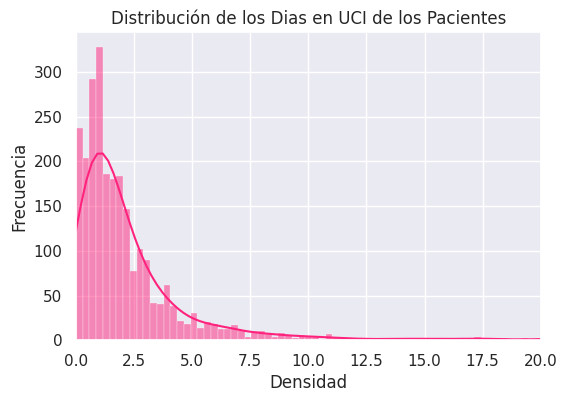

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(data=data, x='target_dias', kde=True, color=(1, 0.137, 0.49), ax=ax)
ax.set(title='Distribución de los Dias en UCI de los Pacientes', xlabel='Densidad', ylabel='Frecuencia', xlim=(0, 20))

# Mostrar el displot
plt.show()

In [ ]:
plt.clf()
plt.cla()
plt.close()

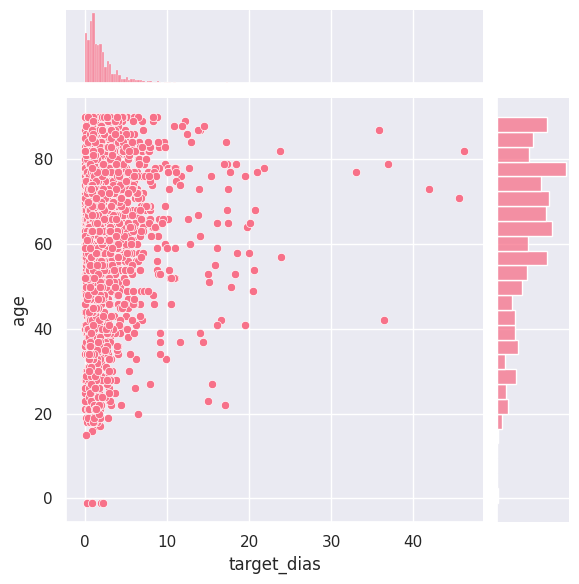

In [ ]:

# Visualizar la correlación entre las columnas "total_bill" y "tip"
sns.jointplot(data=data, x='target_dias', y='age', kind='scatter')

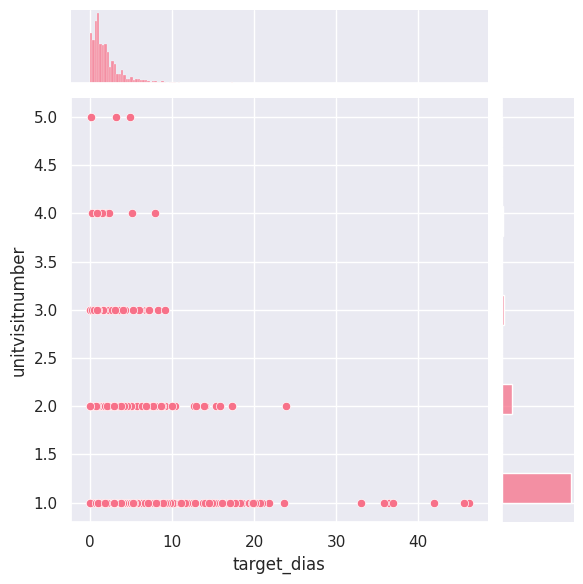

In [ ]:
sns.jointplot(data=data, x='target_dias', y='unitvisitnumber', kind='scatter')

In [ ]:
dataGraf = data.copy()
dataGraf.pop('patientunitstayid')
dataGraf.pop('unitdischargeoffset')
corr_matrix = dataGraf.corr()


<ipython-input-108-8ff44bfc9070>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = dataGraf.corr()


<Axes: >

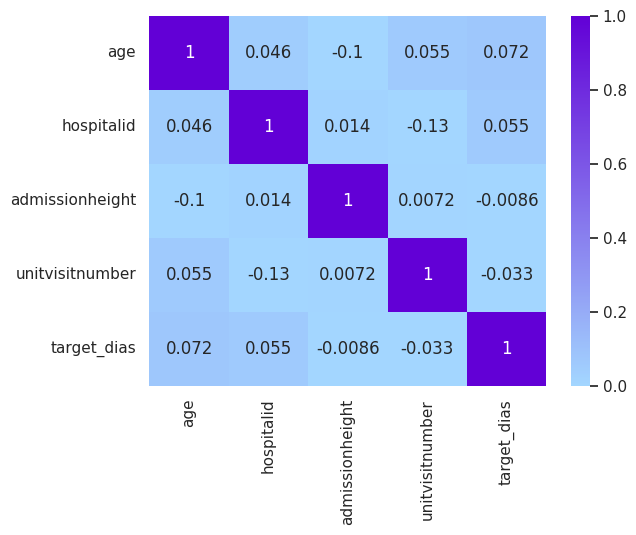

In [ ]:
colors = [(163/255, 214/255, 255/255), (98/255, 0/255, 214/255)]
cmap = mcolors.LinearSegmentedColormap.from_list('Custom', colors, N=256)
# Generar el heatmap
sns.heatmap(corr_matrix, annot=True, cmap=cmap, vmin=0, vmax=1)

# Preprocesado Modelo de datos Final

## Merge Datasets con Patient

In [ ]:
data.shape

(2520, 12)

In [ ]:
# Merge patient con pasthistory
data_v2 = pd.merge(data, paciente_pastHistory, on='patientunitstayid', how='left')

In [ ]:
#Comprobacion de merge correcto
data_v2.shape

(2520, 21)

In [ ]:
# Merge patient con vitalperiodic
data_v3 = pd.merge(data_v2, patient_vital_periodic, on='patientunitstayid', how='left')

In [ ]:
#Comprobacion de merge correcto
data_v3.shape

(2520, 30)

In [ ]:
# Merge patient con hospital
data_v4 = pd.merge(data_v3, hospital, on='hospitalid', how='left')

In [ ]:
#Comprobacion de merge correcto
data_v4.shape

(2520, 31)

In [ ]:
# Merge patient con respiratory Charting
data_v4['en_resCharting'] = data_v4['patientunitstayid'].isin(resCharting['patientunitstayid']).astype(int)

In [ ]:
#Comprobacion de merge correcto
data_v4.shape

(2520, 32)

## Taking Care of Missing Data

### Primeros cambios preestablecidos

In [ ]:
data_v4.dtypes

patientunitstayid           int64
gender                     object
age                         int64
hospitalid                  int64
apacheadmissiondx          object
admissionheight           float64
unittype                   object
unitadmitsource            object
unitvisitnumber             int64
unitstaytype               object
unitdischargeoffset         int64
target_dias               float64
Cardiovascular (R)        float64
Endocrine (R)             float64
Gastrointestinal (R)      float64
Hematology                float64
Infectious Disease (R)    float64
Neurologic                float64
Pulmonary                 float64
Renal  (R)                float64
Rheumatic                 float64
sao2_min                  float64
sao2_max                  float64
sao2_mean                 float64
heartrate_min             float64
heartrate_max             float64
heartrate_mean            float64
respiration_min           float64
respiration_max           float64
respiration_me

In [ ]:
data_v5 = data_v4.loc[data_v4['unitstaytype'] != 'stepdown/other']

In [ ]:
data_v6 = data_v5.loc[~data_v5['apacheadmissiondx'].isna()]

In [ ]:
data_v6 = data_v6.drop('unitstaytype', axis=1)

In [ ]:
data_v6.shape

(2161, 31)

In [ ]:
target = data_v6.pop('unitdischargeoffset')
data_v6 = data_v6.assign(columna=target)
data_v6 = data_v6.rename(columns={'columna': 'target'})

In [ ]:
data_v6.isnull().sum() / data_v6.shape[0]

patientunitstayid         0.000000
gender                    0.001388
age                       0.000000
hospitalid                0.000000
apacheadmissiondx         0.000000
admissionheight           0.018047
unittype                  0.000000
unitadmitsource           0.001851
unitvisitnumber           0.000000
target_dias               0.000000
Cardiovascular (R)        0.180935
Endocrine (R)             0.180935
Gastrointestinal (R)      0.180935
Hematology                0.180935
Infectious Disease (R)    0.180935
Neurologic                0.180935
Pulmonary                 0.180935
Renal  (R)                0.180935
Rheumatic                 0.180935
sao2_min                  0.022212
sao2_max                  0.022212
sao2_mean                 0.022212
heartrate_min             0.022212
heartrate_max             0.022212
heartrate_mean            0.022212
respiration_min           0.022212
respiration_max           0.022212
respiration_mean          0.022212
numbedscategory     

### Categorical Features

In [ ]:
data_v6.select_dtypes(np.object_).loc[:, data_v6.isna().sum() > 0].columns

Index(['gender', 'unitadmitsource'], dtype='object')

In [ ]:
data_v6['gender'] = data_v6['gender'].fillna('Other')

In [ ]:
moda_edad = data_v6['unitadmitsource'].mode()[0]
data_v6['unitadmitsource'] = data_v6['unitadmitsource'].fillna(moda_edad)

### Numerical Features

In [ ]:
media = data_v6.loc[data_v6['age'] != -1, 'age'].mean()
data_v6['age'] = data_v6['age'].replace(-1, media)

In [ ]:
data_v6.select_dtypes(np.number).loc[:, data_v6.isna().sum() > 0].columns

Index(['admissionheight', 'Cardiovascular (R)', 'Endocrine (R)',
       'Gastrointestinal (R)', 'Hematology', 'Infectious Disease (R)',
       'Neurologic', 'Pulmonary', 'Renal  (R)', 'Rheumatic', 'sao2_min',
       'sao2_max', 'sao2_mean', 'heartrate_min', 'heartrate_max',
       'heartrate_mean', 'respiration_min', 'respiration_max',
       'respiration_mean'],
      dtype='object')

In [ ]:
def knn_impute (df, column_na):
  df = df.copy()

  numeric_df = df.select_dtypes(np.number)
  non_na_columns = numeric_df.loc[: , numeric_df.isna().sum() == 0].columns

  y_train = numeric_df.loc[numeric_df[column_na].isna() == False, column_na]
  X_train = numeric_df.loc[numeric_df[column_na].isna() == False, non_na_columns]
  X_test = numeric_df.loc[numeric_df[column_na].isna() == True, non_na_columns]

  knn = KNeighborsRegressor()
  knn.fit(X_train, y_train)

  y_pred = knn.predict(X_test)

  df.loc[df[column_na].isna() == True, column_na] = y_pred

  return df

In [ ]:
data_v6 = knn_impute(data_v6, 'admissionheight')

In [ ]:
data_v6 = knn_impute(data_v6, 'sao2_min')

In [ ]:
data_v6 = knn_impute(data_v6, 'sao2_max')

In [ ]:
data_v6 = knn_impute(data_v6, 'sao2_mean')

In [ ]:
data_v6 = knn_impute(data_v6, 'heartrate_min')

In [ ]:
data_v6 = knn_impute(data_v6, 'heartrate_mean')

In [ ]:
data_v6 = knn_impute(data_v6, 'heartrate_max')

In [ ]:
data_v6 = knn_impute(data_v6, 'respiration_min')

In [ ]:
data_v6 = knn_impute(data_v6, 'respiration_max')

In [ ]:
data_v6 = knn_impute(data_v6, 'respiration_mean')

In [ ]:
data_v6 = data_v6.fillna(0)

In [ ]:
data_v6.select_dtypes(np.number).loc[:, data_v6.isna().sum() > 0].columns

Index([], dtype='object')

## Feature Transforming

### Obtener dias

In [ ]:
data_v6['target_dias'] = data_v6['target']/1440

In [ ]:
data_v6_2cat = data_v6.copy()

In [ ]:
data_v6_2cat.loc[data_v6_2cat['target_dias']<= 3, ['target_dias']] = 0
data_v6_2cat.loc[data_v6_2cat['target_dias']> 3, ['target_dias']] = 1

In [ ]:
data_v6.to_csv(ruta_datasets+"datosResultantes.csv")

In [ ]:
#data_v6.groupby(['target_dias']).size()/data_v6.shape[0]

### Transforming Apache

In [ ]:
#recuentoApache = pd.read_csv(ruta_datasets+"apacheRegistro.csv")

### Transform numeric features with skew normal distribution

In [ ]:
#skew_df = pd.DataFrame(data_v6.select_dtypes(np.number).columns, columns=['Feature'])
#skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data_v6[feature]))
#skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
#skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x>=0.5 else False)
#skew_df

In [ ]:
#for column in ['age', 'admissionheight', 'sao2_min', 'sao2_max', 'sao2_mean', 'respiration_max']:
#  data_v6[column] = np.log1p(data_v6[column])

## Encoding Categorical

In [ ]:
#data_v7 = pd.get_dummies(data_v6, columns=['gender', 'apacheadmissiondx', 'unittype','unitadmitsource'])

In [ ]:
columns_categorical=['gender', 'apacheadmissiondx', 'unittype','unitadmitsource']
count_encoder = CountEncoder()
count_encoder.fit(data_v6_2cat[columns_categorical])
encoded_data = count_encoder.transform(data_v6_2cat[columns_categorical])
data_v7 = data_v6_2cat.drop(columns_categorical, axis=1)
data_v7 = pd.concat([data_v7, encoded_data], axis=1)

In [ ]:
data_v7.shape

(2161, 31)

In [ ]:
data_v7.head()

,patientunitstayid,age,hospitalid,admissionheight,unitvisitnumber,target_dias,Cardiovascular (R),Endocrine (R),Gastrointestinal (R),Hematology,...,respiration_min,respiration_max,respiration_mean,numbedscategory,en_resCharting,target,gender,apacheadmissiondx,unittype,unitadmitsource
1,141765,87.0,59,157.5,1,0.0,0.0,0.0,0.0,0.0,...,17.0,39.0,24.782609,3,0,2250,847,78,1620,1225
2,143870,76.0,68,167.0,1,0.0,0.0,0.0,0.0,0.0,...,45.0,86.0,67.031646,3,1,793,1311,26,71,250
3,144815,34.0,56,172.7,1,0.0,0.0,0.0,0.0,0.0,...,6.0,42.0,16.927273,3,0,1121,847,14,1620,1225
4,145427,61.0,68,177.8,1,0.0,0.0,0.0,0.0,0.0,...,5.0,41.0,16.349206,3,1,1369,1311,13,71,250
6,147307,55.0,63,157.5,1,0.0,0.0,0.0,0.0,0.0,...,12.0,33.0,20.025641,1,1,476,847,26,1620,250


## Scaling

## Split Train and Validation Data

In [ ]:
data_v7.pop('patientunitstayid')
data_v7.pop('target')
target = data_v7.pop('target_dias')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_v7, target, test_size=0.2, random_state=42)

# Train and Validation Model - Clasificacion en periodos

## XGBoost

In [ ]:
modelo = XGBClassifier(n_estimators=500, max_depth=3, learning_rate=0.01, gamma=5)

In [ ]:
param_grid = {
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1],
    'min_child_weight': [0, 1, 5, 10]
}

grid_search = GridSearchCV(modelo, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8267898383371824


In [ ]:
grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## Random Forest 

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

## Validation Model

In [ ]:
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.35).astype(int)

In [ ]:
cm=confusion_matrix(y_test, y_pred)

In [ ]:
cm[0,0] / (cm[0,0]+cm[1,0])

0.8567073170731707

In [ ]:
cm

array([[281,  34],
       [ 47,  71]])

In [ ]:
modelo.fit(X_train, y_train)
y_pred_proba = modelo.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.35).astype(int)

In [ ]:
cm=confusion_matrix(y_test, y_pred)

In [ ]:
cm[0,0] / (cm[0,0]+cm[1,0])

0.8867313915857605

In [ ]:
X_train.columns

Index(['age', 'hospitalid', 'admissionheight', 'unitvisitnumber',
       'Cardiovascular (R)', 'Endocrine (R)', 'Gastrointestinal (R)',
       'Hematology', 'Infectious Disease (R)', 'Neurologic', 'Pulmonary',
       'Renal  (R)', 'Rheumatic', 'sao2_min', 'sao2_max', 'sao2_mean',
       'heartrate_min', 'heartrate_max', 'heartrate_mean', 'respiration_min',
       'respiration_max', 'respiration_mean', 'numbedscategory',
       'en_resCharting', 'gender', 'apacheadmissiondx', 'unittype',
       'unitadmitsource'],
      dtype='object')

In [ ]:
importances = modelo.feature_importances_

# Imprimir la importancia de cada variable
for i in range(len(importances)):
    print(f'Variable {i}: {importances[i]}')

Variable 0: 0.03959211707115173
Variable 1: 0.03113166242837906
Variable 2: 0.029247039929032326
Variable 3: 0.0
Variable 4: 0.024079684168100357
Variable 5: 0.0
Variable 6: 0.0
Variable 7: 0.026427684351801872
Variable 8: 0.0
Variable 9: 0.0
Variable 10: 0.0
Variable 11: 0.04041332006454468
Variable 12: 0.0
Variable 13: 0.14036545157432556
Variable 14: 0.06609632819890976
Variable 15: 0.04732464253902435
Variable 16: 0.06930377334356308
Variable 17: 0.09669391065835953
Variable 18: 0.038507942110300064
Variable 19: 0.04251446947455406
Variable 20: 0.08328305929899216
Variable 21: 0.03726496919989586
Variable 22: 0.035181865096092224
Variable 23: 0.07168083637952805
Variable 24: 0.0
Variable 25: 0.03335084393620491
Variable 26: 0.0
Variable 27: 0.047540485858917236


# Train and Validation 2nd Model

In [ ]:
#Transformación de la variable target
data_v6_regres = data_v6.drop(data_v6.loc[data_v6['target_dias'] > 3].index)

In [ ]:
data_v6_regres.describe()['target_dias']

count    1634.000000
mean        1.339722
std         0.742474
min         0.000000
25%         0.780903
50%         1.173958
75%         1.878125
max         2.995833
Name: target_dias, dtype: float64

## Encoding Categorical

In [ ]:
columns_categorical=['gender', 'apacheadmissiondx', 'unittype','unitadmitsource']
count_encoder = CountEncoder()
count_encoder.fit(data_v6_regres[columns_categorical])
encoded_data = count_encoder.transform(data_v6_regres[columns_categorical])
data_v7_regres = data_v6_regres.drop(columns_categorical, axis=1)
data_v7_regres = pd.concat([data_v7_regres, encoded_data], axis=1)

In [ ]:
data_v7_regres.shape

(1634, 31)

In [ ]:
data_v7_regres.head()

,age,hospitalid,admissionheight,unitvisitnumber,Cardiovascular (R),Endocrine (R),Gastrointestinal (R),Hematology,Infectious Disease (R),Neurologic,...,heartrate_mean,respiration_min,respiration_max,respiration_mean,numbedscategory,en_resCharting,gender,apacheadmissiondx,unittype,unitadmitsource
1,87.0,59,157.5,1,0.0,0.0,0.0,0.0,0.0,0.0,...,87.017817,17.0,39.0,24.782609,3,0,631,65,1232,964
2,76.0,68,167.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,45.449367,45.0,86.0,67.031646,3,1,1000,26,54,198
3,34.0,56,172.7,1,0.0,0.0,0.0,0.0,0.0,0.0,...,83.800000,6.0,42.0,16.927273,3,0,631,13,1232,964
4,61.0,68,177.8,1,0.0,0.0,0.0,0.0,0.0,0.0,...,65.457983,5.0,41.0,16.349206,3,1,1000,11,54,198
6,55.0,63,157.5,1,0.0,0.0,0.0,0.0,0.0,0.0,...,87.085106,12.0,33.0,20.025641,1,1,631,26,1232,198


## Split Train and Validation Data

In [ ]:
data_v7_regres.pop('patientunitstayid')
data_v7_regres.pop('target')
target = data_v7_regres.pop('target_dias')

In [ ]:
X_trainR, X_testR, y_trainR, y_testR = train_test_split(data_v7_regres, target, test_size=0.2, random_state=42)

## XGBoost

In [ ]:
modeloR = XGBRegressor(learning_rate= 0.1, max_depth=3, n_estimators=100, reg_alpha=0)

In [ ]:
param_grid = {
    'min_child_weight': [1, 3, 5],
    'gamma': [0.0, 0.1, 0.2],
    'subsample': [0.5, 0.7, 1.0]
}
grid_search = GridSearchCV(estimator=modeloR, param_grid=param_grid, cv=5)

grid_search.fit(X_trainR, y_trainR)
print(grid_search.best_params_)

{'gamma': 0.1, 'min_child_weight': 1, 'subsample': 1.0}


In [ ]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_testR)

mse = mean_squared_error(y_testR, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.4396229029125584
